In [1]:
import numpy as np
import pandas as pd

In [2]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv',index_col = 0)
loan_data_targets_train = pd.read_csv('loan_data_targets_train.csv', index_col = 0)

In [3]:
loan_data_targets_train

,good_bad
231010,1
204675,1
379340,1
1081690,1
178479,1
...,...
35385,0
1572056,1
851973,1
44515,1


In [4]:
loan_data_inputs_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1335619 entries, 231010 to 60938
Data columns (total 20 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   loan_amnt                      1335619 non-null  float64
 1   term                           1335619 non-null  int64  
 2   int_rate                       1335619 non-null  float64
 3   grade                          1335619 non-null  object 
 4   emp_length                     1335619 non-null  float64
 5   home_ownership                 1335619 non-null  object 
 6   annual_inc                     1335619 non-null  float64
 7   verification_status            1335619 non-null  object 
 8   purpose                        1335619 non-null  object 
 9   addr_state                     1335619 non-null  object 
 10  dti                            1335177 non-null  float64
 11  revol_bal                      1335619 non-null  float64
 12  initial_lis

## 1. Analyze WOE and IVs for categorical and discrete variables

In [5]:
cat_vars = [var for var in loan_data_inputs_train.columns if loan_data_inputs_train[var].dtype == 'O']

In [6]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [7]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 90):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

grade
0.4335015888924477
home_ownership
inf
verification_status
0.06357005743485993
purpose
inf
addr_state
0.014967279307275611
initial_list_status
0.009443345513388119
application_type
0.0033460059113389227


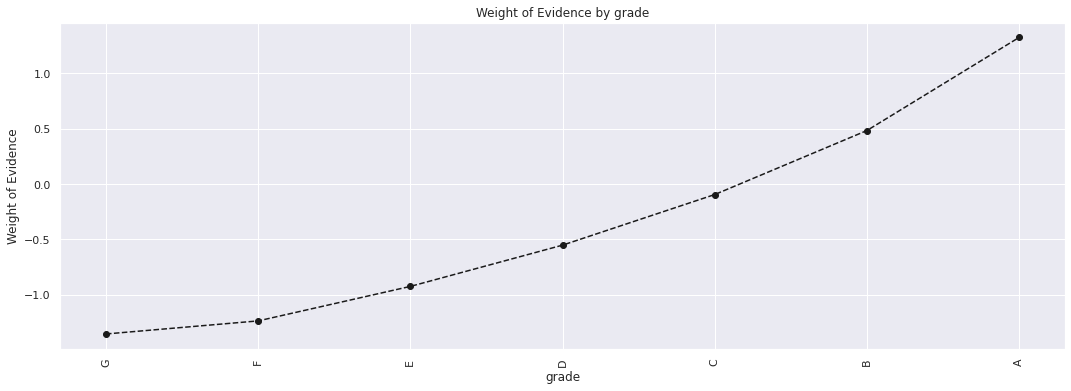

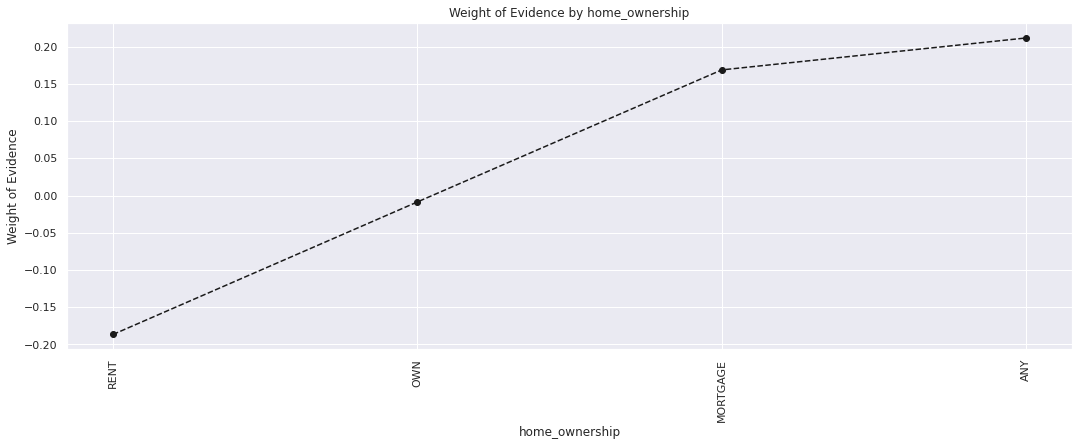

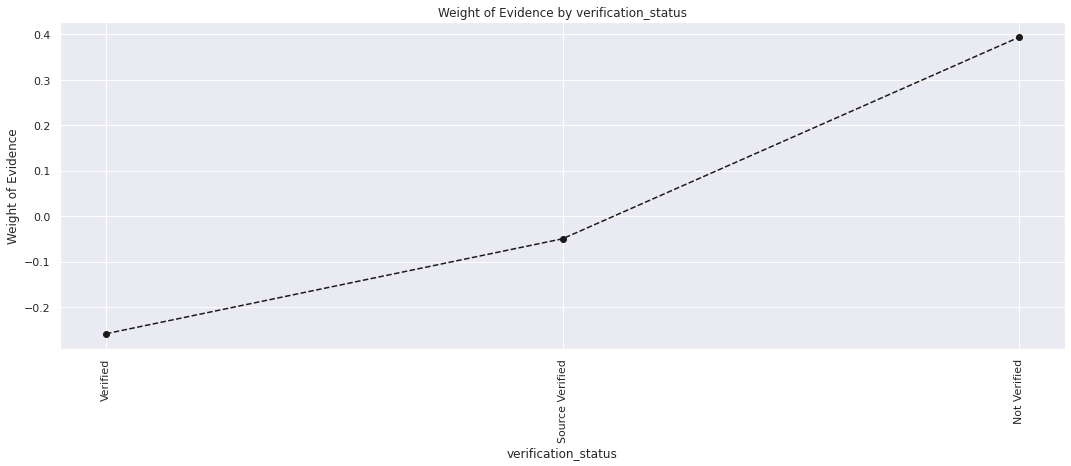

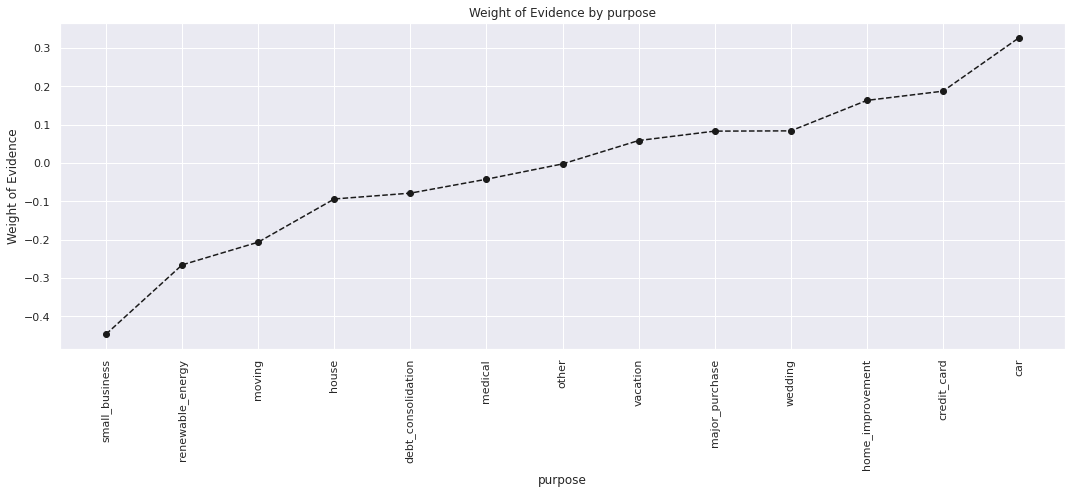

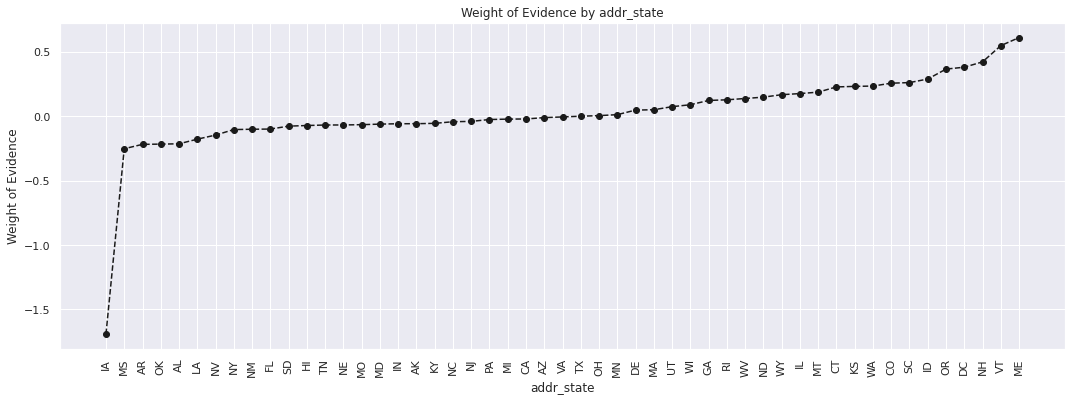

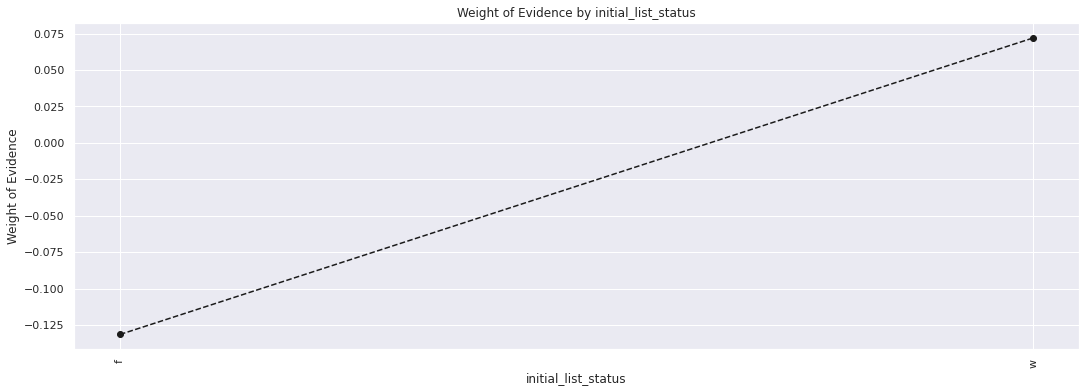

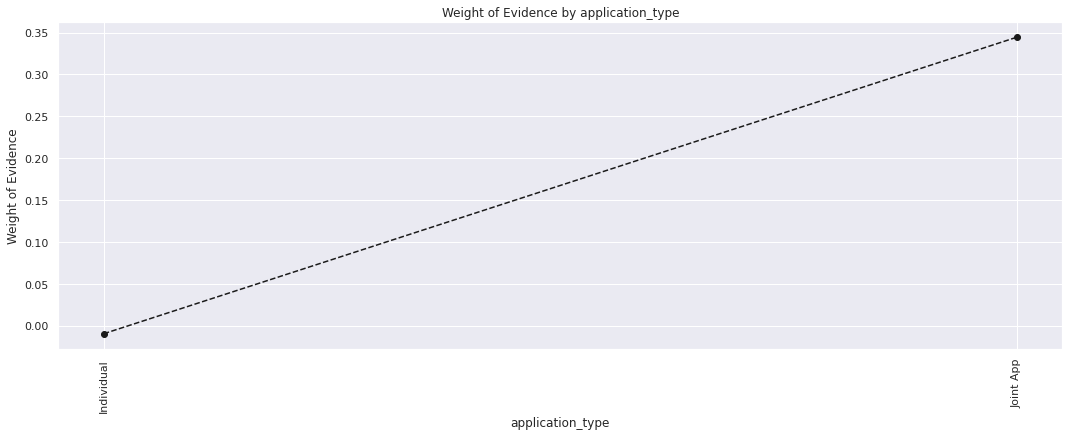

In [9]:
#grade
for var in cat_vars:
    df_temp = woe_discrete(loan_data_inputs_train, var, loan_data_targets_train)
    print(var)
    print(df_temp['IV'][0])
    plot_by_woe(df_temp)

#### sub_grade is a strong indicator, let's also keep verification_status and addr_state. 

#### remove application_type, pub_rec, and initial_list_status because of their low information values

#### let's check home_ownership, address_state and purpose again

In [10]:
ref_cat= ['grade:G', 'verification_status:Verified']

In [11]:
feature_to_remove = ['initial_list_status','application_type']
loan_data_inputs_train.drop(feature_to_remove, axis=1, inplace=True)

In [12]:
df_temp = woe_discrete(loan_data_inputs_train, 'home_ownership', loan_data_targets_train)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,524071,0.818256,0.392381,428824.0,95247.0,0.380243,0.458236,-0.186573,NaN,NaN,inf
1,OWN,148470,0.843234,0.111162,125195.0,23275.0,0.111012,0.111977,-0.008653,0.024979,0.177920,inf
2,MORTGAGE,662659,0.865270,0.496144,573379.0,89280.0,0.508422,0.429528,0.168624,0.022036,0.177277,inf
3,ANY,416,0.870192,0.000311,362.0,54.0,0.000321,0.000260,0.211514,0.004922,0.042891,inf
4,NONE,3,1.000000,0.000002,3.0,0.0,0.000003,0.000000,inf,0.129808,inf,inf


In [13]:
X_train = dummy_creation(loan_data_inputs_train, ['grade','home_ownership', 'verification_status', 'purpose', 'addr_state'])
X_train.loc[(X_train['home_ownership']=='NONE')| 
            (X_train['home_ownership']=="ANY"), 'home_ownership'] = "RENT"
X_train['home_ownership:RENT_NONE_ANY'] = sum([X_train['home_ownership:RENT'], 
                                               X_train['home_ownership:NONE'],X_train['home_ownership:ANY']])

In [14]:
df_temp = woe_discrete(X_train, 'home_ownership', loan_data_targets_train)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,RENT,524490,0.818298,0.392694,429189.0,95301.0,0.380567,0.458495,-0.186289,NaN,NaN,0.027829
1,OWN,148470,0.843234,0.111162,125195.0,23275.0,0.111012,0.111977,-0.008653,0.024937,0.177636,0.027829
2,MORTGAGE,662659,0.865270,0.496144,573379.0,89280.0,0.508422,0.429528,0.168624,0.022036,0.177277,0.027829


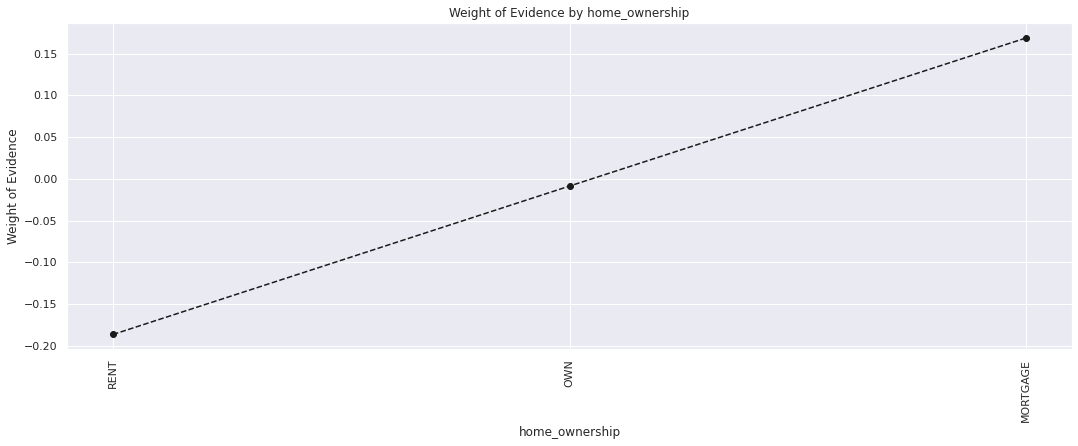

In [15]:
plot_by_woe(df_temp)

In [16]:
ref_cat.append('home_ownership:RENT_NONE_ANY')

In [17]:
df_temp = woe_discrete(loan_data_inputs_train, 'purpose', loan_data_targets_train)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,small_business,13300,0.776391,0.009958,10326.0,2974.0,0.009156,0.014308,-0.446389,NaN,NaN,inf
1,renewable_energy,805,0.806211,0.000603,649.0,156.0,0.000575,0.000751,-0.265569,0.029820,0.180820,inf
2,moving,9085,0.815300,0.006802,7407.0,1678.0,0.006568,0.008073,-0.206323,0.009089,0.059246,inf
3,house,6315,0.831671,0.004728,5252.0,1063.0,0.004657,0.005114,-0.093632,0.016371,0.112691,inf
4,debt_consolidation,774546,0.833790,0.579915,645809.0,128737.0,0.572646,0.619357,-0.078414,0.002120,0.015218,inf
5,medical,15455,0.838758,0.011571,12963.0,2492.0,0.011494,0.011989,-0.042132,0.004967,0.036281,inf
6,other,77474,0.844090,0.058006,65395.0,12079.0,0.057986,0.058112,-0.002168,0.005332,0.039964,inf
7,vacation,9017,0.851946,0.006751,7682.0,1335.0,0.006812,0.006423,0.058803,0.007857,0.060971,inf
8,major_purchase,28093,0.855017,0.021034,24020.0,4073.0,0.021299,0.019595,0.083361,0.003071,0.024558,inf
9,wedding,490,0.855102,0.000367,419.0,71.0,0.000372,0.000342,0.084045,0.000085,0.000684,inf


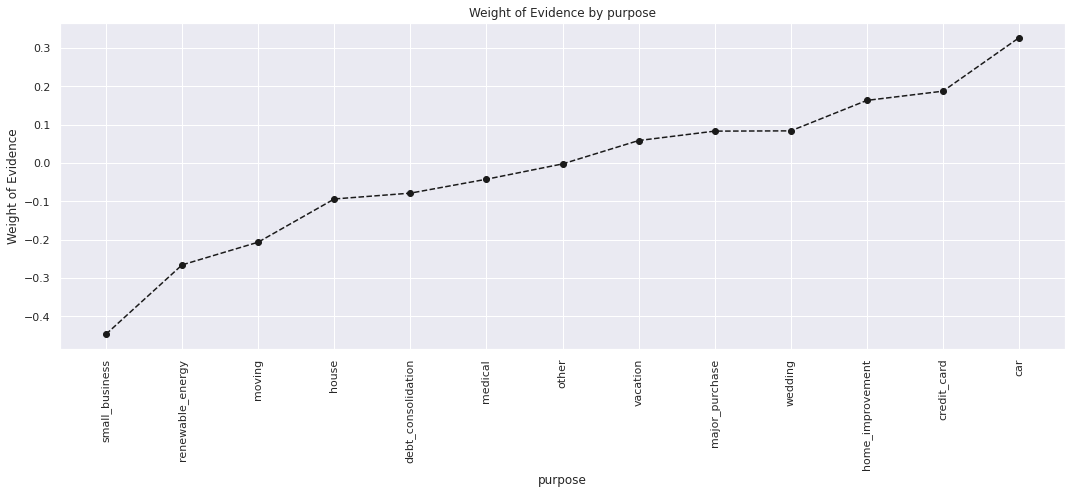

In [18]:
plot_by_woe(df_temp)

In [19]:
# We create the following categories:
# 'small_business' 
# 'RE_MV_HS"
# 'debt_consolidation'
# 'Med_other_wed'
# 'Vac_MajP'
# 'Home_Cred'
# 'Car_Edu'

# 'smlbsn' will be the reference category
#X_train = dummy_creation(loan_data_inputs_train, ['purpose'])
X_train['purpose:RE_MV_HS'] = sum([X_train['purpose:renewable_energy'],X_train['purpose:moving'],
                                  X_train['purpose:house']])
X_train['purpose:med_other_wed'] = sum([X_train['purpose:medical'], X_train['purpose:other'],
                                       X_train['purpose:wedding']])
X_train['purpose:vac_majp'] = sum([X_train['purpose:vacation'], X_train['purpose:major_purchase']])
X_train['purpose:home_cred'] = sum([X_train['purpose:home_improvement'], X_train['purpose:credit_card']])
X_train['purpose:car_edu']=sum([X_train['purpose:car'], X_train['purpose:educational']])

In [20]:
ref_cat.append('purpose:small_business')

In [21]:
df_temp = woe_discrete(loan_data_inputs_train, 'addr_state', loan_data_targets_train)
df_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,IA,2,0.500000,0.000001,1.0,1.0,8.867111e-07,0.000005,-1.691146,NaN,NaN,0.014967
1,MS,7606,0.808441,0.005695,6149.0,1457.0,5.452387e-03,0.007010,-0.251236,0.308441,1.439910,0.014967
2,AR,10081,0.813610,0.007548,8202.0,1879.0,7.272805e-03,0.009040,-0.217507,0.005169,0.033728,0.014967
3,OK,12220,0.813912,0.009149,9946.0,2274.0,8.819229e-03,0.010940,-0.215516,0.000302,0.001992,0.014967
4,AL,16417,0.814278,0.012292,13368.0,3049.0,1.185355e-02,0.014669,-0.213096,0.000366,0.002420,0.014967
5,LA,15449,0.819665,0.011567,12663.0,2786.0,1.122842e-02,0.013404,-0.177068,0.005387,0.036027,0.014967
6,NV,18964,0.824299,0.014199,15632.0,3332.0,1.386107e-02,0.016030,-0.145398,0.004634,0.031670,0.014967
7,NY,110390,0.830419,0.082651,91670.0,18720.0,8.128481e-02,0.090062,-0.102543,0.006121,0.042855,0.014967
8,NM,7097,0.830774,0.005314,5896.0,1201.0,5.228049e-03,0.005778,-0.100026,0.000354,0.002517,0.014967
9,FL,93853,0.830980,0.070269,77990.0,15863.0,6.915460e-02,0.076317,-0.098555,0.000207,0.001472,0.014967


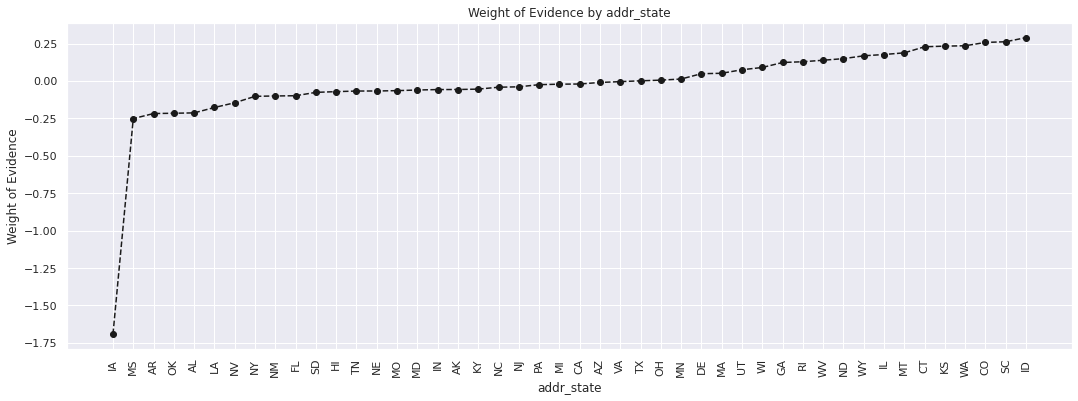

In [22]:
plot_by_woe(df_temp.iloc[:-5])

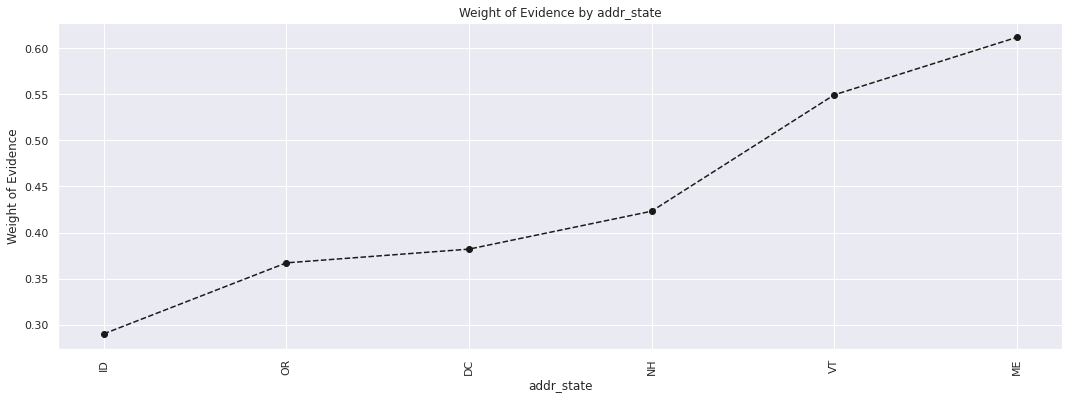

In [23]:
plot_by_woe(df_temp.iloc[-6:])

In [24]:
# We create the following categories:
# 'AR' 'MS' 'AL' OK' 'LA' 
# 'NV' 'NM' "SD"
# 'NY'
# 'FL' 'NE' 'TN' 'HI' 'MO' 'MD'
# 'NJ' 'NC' 'IN' 'KY'
# 'CA'
# 'PA' 'VA' 'AK' 
# 'AZ' 'MI'
# 'TX'
# 'OH' 'MN' 'DE'
# 'MA'
# 'WI' 'UT' 'GA' 'WV' 'RI'
# 'ND' 'WY' 'IL' 
# 'MT' 'KS' 'ID'
# 'WA' 'CT' 'CO' 'SC'
# 'NH' 'OR' 'DC' 'VT' 'ME'

# 'AR_MS_AL_OK_LA' will be the reference category
#X_train = dummy_creation(loan_data_inputs_train, ['addr_state'])

X_train['addr_state:IA_AR_MS_AL_OK_LA'] = sum([X_train['addr_state:AR'], X_train['addr_state:MS'],
                                               X_train['addr_state:AL'], X_train['addr_state:OK'],
                                               X_train['addr_state:LA'], X_train['addr_state:IA']])
X_train['addr_state:NV_NM_SD'] = sum([X_train['addr_state:NV'],X_train['addr_state:NM'],X_train['addr_state:SD']])
X_train['addr_state:FL_NE_TN_HI_MO_MD'] = sum([X_train['addr_state:FL'],X_train['addr_state:NE'],
                                               X_train['addr_state:TN'],X_train['addr_state:HI'],
                                               X_train['addr_state:MO'],X_train['addr_state:MD']])
X_train['addr_state:NJ_NC_IN_KY'] = sum([X_train['addr_state:NJ'], X_train['addr_state:NC'], 
                                         X_train['addr_state:IN'], X_train['addr_state:KY']])
X_train['addr_state:PA_VA_AK']=sum([X_train['addr_state:PA'], X_train['addr_state:VA'], X_train['addr_state:AK']])
X_train['addr_state:AZ_MI'] = sum([X_train['addr_state:AZ'], X_train['addr_state:MI']])
X_train['addr_state:WI_UT_GA_WV_RI'] = sum([X_train['addr_state:WI'], X_train['addr_state:UT'], 
                                            X_train['addr_state:GA'], X_train['addr_state:WV'], 
                                            X_train['addr_state:RI']])
X_train['addr_state:OH_MN_DE'] = sum([X_train['addr_state:OH'], X_train['addr_state:MN'], X_train['addr_state:DE']])
X_train['addr_state:ND_WY_IL'] = sum([X_train['addr_state:ND'], X_train['addr_state:WY'], X_train['addr_state:IL']])
X_train['addr_state:MT_KS_ID'] = sum([X_train['addr_state:MT'], X_train['addr_state:KS'], X_train['addr_state:ID']])
X_train['addr_state:WA_CT_CO_SC'] = sum([X_train['addr_state:WA'], X_train['addr_state:CT'], 
                                         X_train['addr_state:CO'], X_train['addr_state:SC']])
X_train['addr_state:NH_OR_DC_VT_ME'] = sum([X_train['addr_state:NH'], X_train['addr_state:OR'],
                                            X_train['addr_state:DC'], X_train['addr_state:VT'], 
                                            X_train['addr_state:ME']])

In [25]:
ref_cat.append('addr_state:IA_AR_MS_AL_OK_LA')

## 2. Check numerical variables

In [26]:
num_vars = [var for var in loan_data_inputs_train.columns if var not in cat_vars]

In [27]:
num_vars

['loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'annual_inc',
 'dti',
 'revol_bal',
 'all_util',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'mths_since_last_credit_pull_d',
 'mths_credit_history']

In [28]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [29]:
# fine-classing using the 'cut' method, given the large number of unique values
loan_data_inputs_train['loan_amnt_factor'] = pd.qcut(loan_data_inputs_train['loan_amnt'], 100, duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'loan_amnt_factor', loan_data_targets_train)
df_temp

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(999.999, 1600.0]",13916,0.903277,0.010419,12570.0,1346.0,0.011146,0.006476,0.543030,NaN,NaN,0.036812
1,"(1600.0, 2200.0]",13803,0.881258,0.010335,12164.0,1639.0,0.010786,0.007885,0.313249,0.022019,0.229781,0.036812
2,"(2200.0, 2800.0]",14010,0.883298,0.010490,12375.0,1635.0,0.010973,0.007866,0.332890,0.002040,0.019641,0.036812
3,"(2800.0, 3000.0]",17665,0.879083,0.013226,15529.0,2136.0,0.013770,0.010276,0.292629,0.004215,0.040261,0.036812
4,"(3000.0, 3500.0]",12653,0.880345,0.009474,11139.0,1514.0,0.009877,0.007284,0.304552,0.001262,0.011923,0.036812
...,...,...,...,...,...,...,...,...,...,...,...,...
56,"(28000.0, 30000.0]",41755,0.828691,0.031263,34602.0,7153.0,0.030682,0.034413,-0.114766,0.016468,0.120750,0.036812
57,"(30000.0, 32000.0]",13672,0.818607,0.010236,11192.0,2480.0,0.009924,0.011931,-0.184205,0.010084,0.069439,0.036812
58,"(32000.0, 35000.0]",63072,0.812310,0.047223,51234.0,11838.0,0.045430,0.056953,-0.226057,0.006298,0.041852,0.036812
59,"(35000.0, 36000.0]",2679,0.918253,0.002006,2460.0,219.0,0.002181,0.001054,0.727699,0.105943,0.953756,0.036812


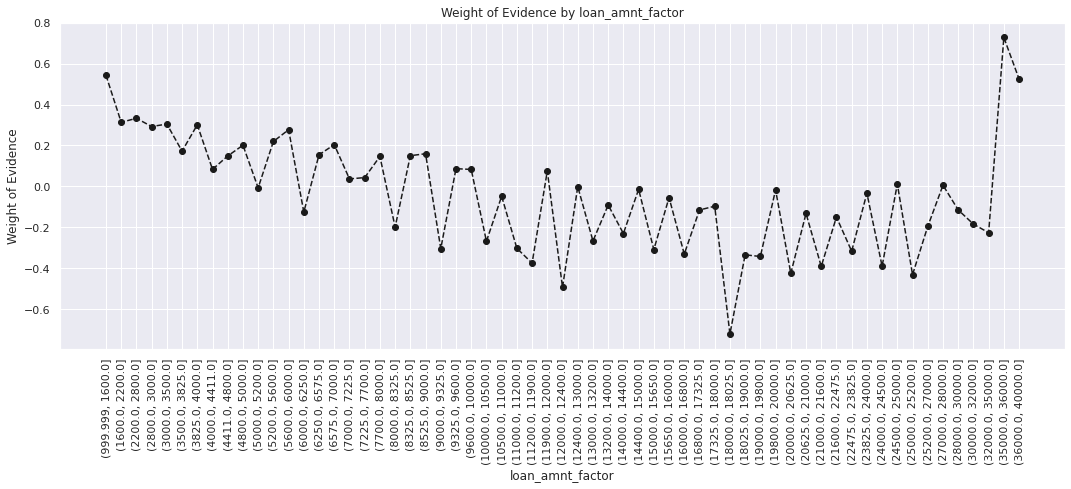

In [30]:
plot_by_woe(df_temp, 90)

In [31]:
#loan_amnt:<=4000 will be the reference variable
X_train['loan_amnt:<=1600'] = np.where(X_train['loan_amnt']<=1600, 1, 0)
X_train['loan_amnt:1600-3500'] = np.where((X_train['loan_amnt']>1600) & (X_train['loan_amnt']<=3500), 1, 0)
X_train['loan_amnt:3500-5000'] = np.where((X_train['loan_amnt']>3500) & (X_train['loan_amnt']<=5000), 1, 0)
X_train['loan_amnt:5000-6000'] = np.where((X_train['loan_amnt']>5000) & (X_train['loan_amnt']<=6000), 1, 0)
X_train['loan_amnt:6000-7000'] = np.where((X_train['loan_amnt']>6000) & (X_train['loan_amnt']<=7000), 1, 0)
X_train['loan_amnt:7000-8000'] = np.where((X_train['loan_amnt']>7000) & (X_train['loan_amnt']<=8000), 1, 0)
X_train['loan_amnt:8000-9000'] = np.where((X_train['loan_amnt']>8000) & (X_train['loan_amnt']<=9000), 1, 0)
X_train['loan_amnt:9000-10000'] = np.where((X_train['loan_amnt']>9000) & (X_train['loan_amnt']<=10000), 1, 0)
X_train['loan_amnt:10000-35000'] = np.where((X_train['loan_amnt']>10000) & (X_train['loan_amnt']<=35000), 1, 0)
X_train['loan_amnt:>35000'] = np.where(X_train['loan_amnt']>35000, 1, 0)

ref_cat.append('loan_amnt:10000-35000')

In [32]:
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'term', loan_data_targets_train)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,951799,0.868138,0.712628,826293.0,125506.0,0.732683,0.603812,0.193450,NaN,NaN,0.075635
1,60,383820,0.785446,0.287372,301470.0,82350.0,0.267317,0.396188,-0.393454,0.082692,0.586904,0.075635


In [33]:
# Leave as is.
# '60' will be the reference category.
X_train['term:36'] = np.where((X_train['term'] == 36), 1, 0)
X_train['term:60'] = np.where((X_train['term'] == 60), 1, 0)
ref_cat.append('term:60')

In [34]:
loan_data_inputs_train['int_rate_factor'] = pd.cut(loan_data_inputs_train['int_rate'], 8, duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'int_rate_factor', loan_data_targets_train)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.294, 8.529]",248645,0.948589,0.186165,235862.0,12783.0,0.209141,0.061499,1.223985,NaN,NaN,0.398393
1,"(8.529, 11.738]",311628,0.898157,0.233321,279891.0,31737.0,0.248182,0.152687,0.485771,0.050432,0.738214,0.398393
2,"(11.738, 14.946]",350706,0.841254,0.262579,295033.0,55673.0,0.261609,0.267844,-0.023554,0.056903,0.509325,0.398393
3,"(14.946, 18.155]",233455,0.787869,0.174792,183932.0,49523.0,0.163095,0.238256,-0.379017,0.053385,0.355463,0.398393
4,"(18.155, 21.364]",106132,0.715892,0.079463,75979.0,30153.0,0.067371,0.145067,-0.766973,0.071978,0.387956,0.398393
5,"(21.364, 24.572]",48990,0.687998,0.036680,33705.0,15285.0,0.029887,0.073536,-0.900372,0.027894,0.133398,0.398393
6,"(24.572, 27.781]",24991,0.653875,0.018711,16341.0,8650.0,0.014490,0.041615,-1.055028,0.034122,0.154656,0.398393
7,"(27.781, 30.99]",11072,0.634032,0.008290,7020.0,4052.0,0.006225,0.019494,-1.141593,0.019844,0.086565,0.398393


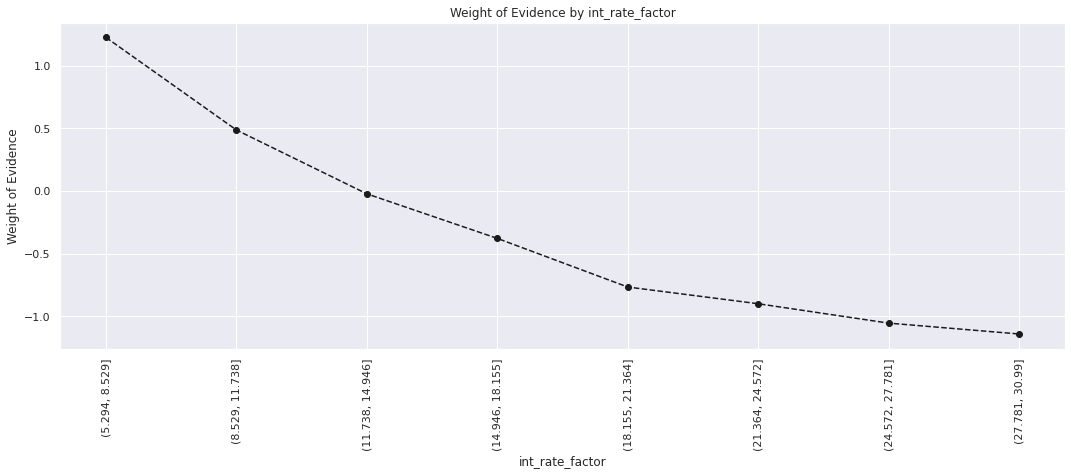

In [35]:
plot_by_woe(df_temp, 90)

In [36]:
#int_rate:<=4000 will be the reference variable
X_train['int_rate:<=8.529'] = np.where(X_train['int_rate']<=8.529, 1, 0)
X_train['int_rate:8.529-11.738'] = np.where((X_train['int_rate']>8.529) & (X_train['int_rate']<=11.738), 1, 0)
X_train['int_rate:11.738-14.946'] = np.where((X_train['int_rate']>11.738) & (X_train['int_rate']<=14.946), 1, 0)
X_train['int_rate:14.946-18.155'] = np.where((X_train['int_rate']>14.946) & (X_train['int_rate']<=18.155), 1, 0)
X_train['int_rate:18.155-21.364'] = np.where((X_train['int_rate']>18.155) & (X_train['int_rate']<=21.364), 1, 0)
X_train['int_rate:>21.364'] = np.where(X_train['int_rate']>21.364, 1, 0)
ref_cat.append('int_rate:>21.364')

In [37]:
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'emp_length', loan_data_targets_train)
df_temp

,emp_length,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,191246,0.824158,0.143189,157617.0,33629.0,0.139761,0.161790,-0.146367,NaN,NaN,0.00613
1,1.0,86305,0.837414,0.064618,72273.0,14032.0,0.064085,0.067508,-0.052036,0.013255,0.094331,0.00613
2,2.0,119304,0.844775,0.089325,100785.0,18519.0,0.089367,0.089095,0.003047,0.007361,0.055082,0.00613
3,3.0,105550,0.842814,0.079027,88959.0,16591.0,0.078881,0.079820,-0.011831,0.001961,0.014877,0.00613
4,4.0,78179,0.844153,0.058534,65995.0,12184.0,0.058519,0.058618,-0.001690,0.001339,0.010140,0.00613
5,5.0,80668,0.845453,0.060397,68201.0,12467.0,0.060475,0.059979,0.008228,0.001300,0.009919,0.00613
6,6.0,59775,0.846725,0.044755,50613.0,9162.0,0.044879,0.044079,0.017998,0.001272,0.009770,0.00613
7,7.0,55872,0.842121,0.041832,47051.0,8821.0,0.041721,0.042438,-0.017049,0.004604,0.035047,0.00613
8,8.0,57554,0.835285,0.043092,48074.0,9480.0,0.042628,0.045608,-0.067589,0.006836,0.050540,0.00613
9,9.0,50664,0.844762,0.037933,42799.0,7865.0,0.037950,0.037839,0.002946,0.009476,0.070535,0.00613


we will exclude this for its low Information value

In [38]:
#annual_inc
loan_data_inputs_train['annual_inc_factor'] = pd.qcut(loan_data_inputs_train['annual_inc'], 10,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'annual_inc_factor', loan_data_targets_train)
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 35000.0]",153202,0.811314,0.114705,124295.0,28907.0,0.110214,0.139072,-0.232572,NaN,NaN,0.031462
1,"(35000.0, 43000.0]",121932,0.820687,0.091293,100068.0,21864.0,0.088731,0.105188,-0.170137,0.009372,0.062435,0.031462
2,"(43000.0, 50000.0]",141699,0.827748,0.106092,117291.0,24408.0,0.104003,0.117427,-0.121399,0.007061,0.048739,0.031462
3,"(50000.0, 58000.0]",120684,0.833955,0.090358,100645.0,20039.0,0.089243,0.096408,-0.077227,0.006207,0.044172,0.031462
4,"(58000.0, 65000.0]",140531,0.835467,0.105218,117409.0,23122.0,0.104108,0.111240,-0.066267,0.001512,0.010960,0.031462
5,"(65000.0, 75000.0]",144936,0.846063,0.108516,122625.0,22311.0,0.108733,0.107339,0.012905,0.010596,0.079172,0.031462
6,"(75000.0, 85000.0]",115782,0.851739,0.086688,98616.0,17166.0,0.087444,0.082586,0.057157,0.005676,0.044252,0.031462
7,"(85000.0, 100000.0]",134792,0.861713,0.100921,116152.0,18640.0,0.102993,0.089677,0.138444,0.009974,0.081287,0.031462
8,"(100000.0, 130000.0]",137735,0.872865,0.103124,120224.0,17511.0,0.106604,0.084246,0.235382,0.011152,0.096938,0.031462
9,"(130000.0, 110000000.0]",124326,0.888294,0.093085,110438.0,13888.0,0.097927,0.066815,0.382283,0.015429,0.146902,0.031462


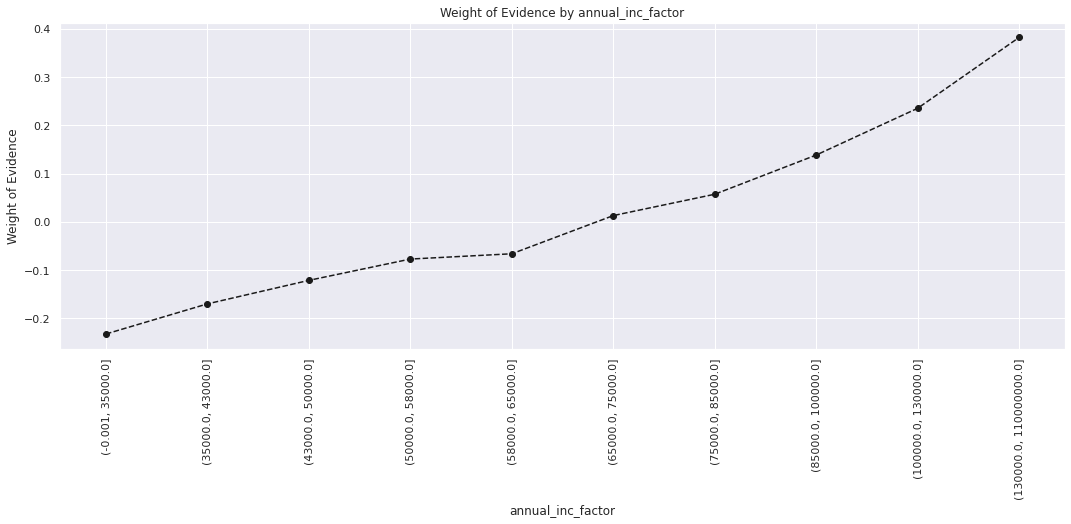

In [39]:
plot_by_woe(df_temp, 90)

In [40]:
X_train['annual_inc:<35K'] = np.where((X_train['annual_inc'] <= 35000), 1, 0)
X_train['annual_inc:35K-43K'] = np.where((X_train['annual_inc'] > 35000) & (X_train['annual_inc'] <= 43000), 1, 0)
X_train['annual_inc:43K-50K'] = np.where((X_train['annual_inc'] > 43000) & (X_train['annual_inc'] <= 50000), 1, 0)
X_train['annual_inc:50K-58K'] = np.where((X_train['annual_inc'] > 50000) & (X_train['annual_inc'] <= 58000), 1, 0)
X_train['annual_inc:58K-65K'] = np.where((X_train['annual_inc'] > 58000) & (X_train['annual_inc'] <= 65000), 1, 0)
X_train['annual_inc:65K-75K'] = np.where((X_train['annual_inc'] > 65000) & (X_train['annual_inc'] <= 75000), 1, 0)
X_train['annual_inc:75K-85K'] = np.where((X_train['annual_inc'] > 75000) & (X_train['annual_inc'] <= 85000), 1, 0)
X_train['annual_inc:85K-100K'] = np.where((X_train['annual_inc'] > 85000) & (X_train['annual_inc'] <= 100000), 1, 0)
X_train['annual_inc:100K-130K'] = np.where((X_train['annual_inc'] > 100000) & (X_train['annual_inc'] <= 130000), 1, 0)
X_train['annual_inc:>130K'] = np.where((X_train['annual_inc'] > 130000), 1, 0)

ref_cat.append('annual_inc:<35K')

In [41]:
#dti
#pd.cut(test.days, [0,30,60], include_lowest=True)
loan_data_inputs_train['dti_factor'] = pd.cut(loan_data_inputs_train.dti, [-1.1, 5, 10, 15, 20, 25, 30, 999],include_lowest=True,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'dti_factor', loan_data_targets_train)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1.101, 5.0]",59792,0.883580,0.044782,52831.0,6961.0,0.046862,0.033497,0.335765,NaN,NaN,0.050585
1,"(5.0, 10.0]",167555,0.881764,0.125493,147744.0,19811.0,0.131052,0.095332,0.318234,0.001816,0.017531,0.050585
2,"(10.0, 15.0]",265192,0.868740,0.198619,230383.0,34809.0,0.204355,0.167503,0.198857,0.013024,0.119377,0.050585
3,"(15.0, 20.0]",284356,0.850997,0.212973,241986.0,42370.0,0.214647,0.203887,0.051429,0.017744,0.147428,0.050585
4,"(20.0, 25.0]",241220,0.831614,0.180665,200602.0,40618.0,0.177939,0.195456,-0.093899,0.019382,0.145328,0.050585
5,"(25.0, 30.0]",176041,0.810732,0.131848,142722.0,33319.0,0.126598,0.160333,-0.236239,0.020883,0.142341,0.050585
6,"(30.0, 999.0]",141021,0.787812,0.105620,111098.0,29923.0,0.098547,0.143991,-0.379225,0.022920,0.142986,0.050585


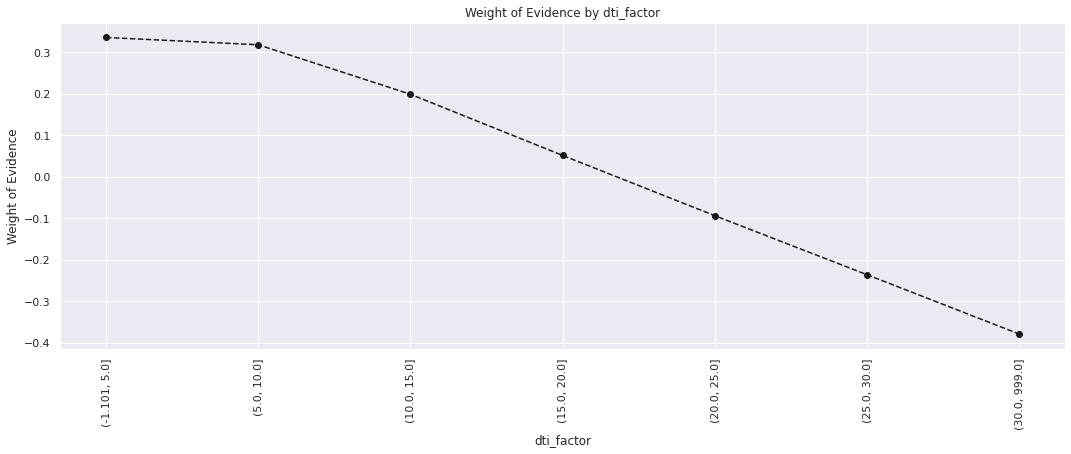

In [42]:
plot_by_woe(df_temp, 90)

In [43]:
X_train['dti:<10'] = np.where((X_train['dti'] <= 10)|(X_train['dti'].isnull()), 1, 0)
X_train['dti:10-15'] = np.where((X_train['dti'] > 10) & (X_train['dti'] <= 15), 1, 0)
X_train['dti:15-20'] = np.where((X_train['dti'] > 15) & (X_train['dti'] <= 20), 1, 0)
X_train['dti:20-25'] = np.where((X_train['dti'] > 20) & (X_train['dti'] <= 25), 1, 0)
X_train['dti:25-30'] = np.where((X_train['dti'] > 25) & (X_train['dti'] <= 30), 1, 0)
X_train['dti:>30'] = np.where((X_train['dti'] > 30), 1, 0)

ref_cat.append('dti:>30')

In [44]:
#revol_bal
loan_data_inputs_train['revol_bal_factor'] = pd.qcut(loan_data_inputs_train['revol_bal'], 200,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'revol_bal_factor', loan_data_targets_train)
df_temp

,revol_bal_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 27.0]",6716,0.856611,0.005028,5753.0,963.0,0.005101,0.004633,0.096278,NaN,NaN,0.009549
1,"(27.0, 255.0]",6663,0.841813,0.004989,5609.0,1054.0,0.004974,0.005071,-0.019366,0.014798,0.115643,0.009549
2,"(255.0, 503.0]",6690,0.841405,0.005009,5629.0,1061.0,0.004991,0.005104,-0.022426,0.000408,0.003060,0.009549
3,"(503.0, 735.0]",6665,0.845761,0.004990,5637.0,1028.0,0.004998,0.004946,0.010591,0.004356,0.033017,0.009549
4,"(735.0, 949.0]",6665,0.846212,0.004990,5640.0,1025.0,0.005001,0.004931,0.014046,0.000450,0.003455,0.009549
...,...,...,...,...,...,...,...,...,...,...,...,...
195,"(61143.0, 68622.64]",6676,0.881067,0.004998,5882.0,794.0,0.005216,0.003820,0.311423,0.004438,0.041688,0.009549
196,"(68622.64, 79759.92]",6678,0.891884,0.005000,5956.0,722.0,0.005281,0.003474,0.418983,0.010817,0.107561,0.009549
197,"(79759.92, 99127.64]",6678,0.890836,0.005000,5949.0,729.0,0.005275,0.003507,0.408159,0.001048,0.010825,0.009549
198,"(99127.64, 140876.19]",6678,0.896825,0.005000,5989.0,689.0,0.005311,0.003315,0.471293,0.005990,0.063134,0.009549


will drop this variable for its low information value

In [45]:
#all_util
loan_data_inputs_train['all_util_factor'] = pd.cut(loan_data_inputs_train.all_util, [-1, 30, 40, 50, 60, 70, 80, 90, 210],  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'all_util_factor', loan_data_targets_train)
df_temp

,all_util_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1, 30]",68767,0.902351,0.095597,62052.0,6715.0,0.100073,0.067641,0.391683,NaN,NaN,0.040772
1,"(30, 40]",70129,0.894109,0.097490,62703.0,7426.0,0.101123,0.074803,0.301476,0.008242,0.090207,0.040772
2,"(40, 50]",102426,0.881934,0.142388,90333.0,12093.0,0.145682,0.121814,0.178931,0.012175,0.122546,0.040772
3,"(50, 60]",129511,0.864073,0.180041,111907.0,17604.0,0.180475,0.177327,0.017597,0.017861,0.161334,0.040772
4,"(60, 70]",135745,0.849239,0.188707,115280.0,20465.0,0.185915,0.206147,-0.103298,0.014834,0.120894,0.040772
5,"(70, 80]",110823,0.836983,0.154062,92757.0,18066.0,0.149592,0.181981,-0.195994,0.012256,0.092696,0.040772
6,"(80, 90]",65054,0.830479,0.090435,54026.0,11028.0,0.087129,0.111086,-0.242918,0.006504,0.046924,0.040772
7,"(90, 210]",36887,0.840676,0.051279,31010.0,5877.0,0.050011,0.059200,-0.168682,0.010196,0.074235,0.040772


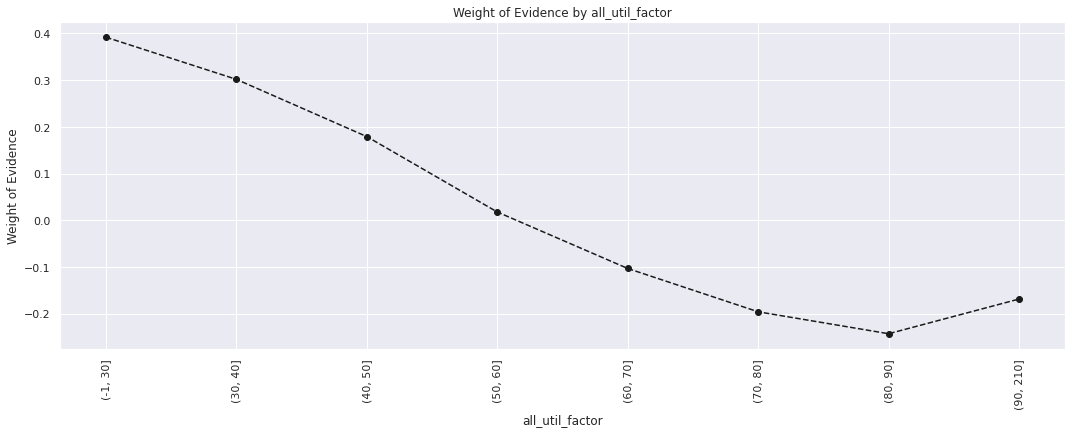

In [46]:
plot_by_woe(df_temp, 90)

In [47]:
X_train['all_util:<=30'] = np.where(X_train['all_util']<=30, 1, 0)
X_train['all_util:missing'] = np.where(X_train['all_util'].isnull(), 1, 0)
X_train['all_util:30-40'] = np.where((X_train['all_util'] >30) & (X_train['all_util']<=40), 1, 0)
X_train['all_util:40-50'] = np.where((X_train['all_util'] >40) & (X_train['all_util']<=50), 1, 0)
X_train['all_util:50-60'] = np.where((X_train['all_util'] >50) & (X_train['all_util']<=60), 1, 0)
X_train['all_util:60-70'] = np.where((X_train['all_util'] >60) & (X_train['all_util']<=70), 1, 0)
X_train['all_util:>70'] = np.where((X_train['all_util'] >70), 1, 0)

ref_cat.append('all_util:>70')

In [48]:
#mort_acc
loan_data_inputs_train['mort_acc_factor'] = pd.qcut(loan_data_inputs_train['mort_acc'], 2,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'mort_acc_factor', loan_data_targets_train)
df_temp

,mort_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 1.0]",781761,0.827753,0.585317,647105.0,134656.0,0.573795,0.647833,-0.121361,NaN,NaN,0.023113
1,"(1.0, 94.0]",553858,0.867836,0.414683,480658.0,73200.0,0.426205,0.352167,0.190815,0.040083,0.312175,0.023113


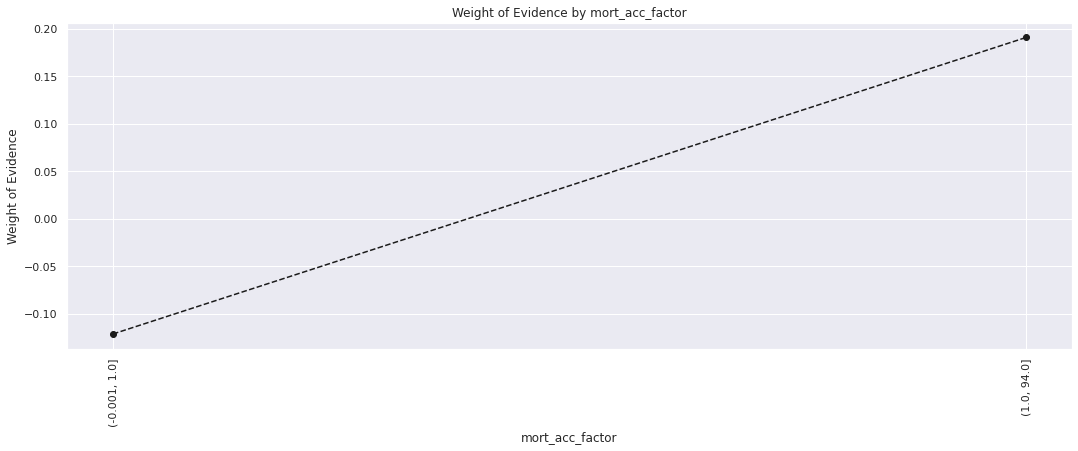

In [49]:
plot_by_woe(df_temp, 90)

In [50]:
# Leave as is.
# '60' will be the reference category.
X_train['mort_acc:0'] = np.where((X_train['mort_acc'] == 0), 1, 0)
X_train['mort_acc:none-zero'] = np.where((X_train['mort_acc'] != 0), 1, 0)
ref_cat.append('mort_acc:0')

In [51]:
#mths_since_recent_bc
loan_data_inputs_train['mths_since_recent_bc_factor'] = pd.qcut(loan_data_inputs_train['mths_since_recent_bc'], 24,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'mths_since_recent_bc_factor', loan_data_targets_train)
df_temp

,mths_since_recent_bc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 2.0]",112844,0.806680,0.085347,91029.0,21815.0,0.081535,0.106033,-0.262717,NaN,NaN,0.034193
1,"(2.0, 3.0]",64420,0.817308,0.048723,52651.0,11769.0,0.047160,0.057204,-0.193081,0.010628,0.069636,0.034193
2,"(3.0, 4.0]",61696,0.823765,0.046663,50823.0,10873.0,0.045523,0.052849,-0.149231,0.006457,0.043850,0.034193
3,"(4.0, 5.0]",58178,0.828561,0.044002,48204.0,9974.0,0.043177,0.048479,-0.115837,0.004796,0.033394,0.034193
4,"(5.0, 6.0]",54113,0.829061,0.040927,44863.0,9250.0,0.040184,0.044960,-0.112307,0.000501,0.003530,0.034193
5,"(6.0, 7.0]",51503,0.827505,0.038953,42619.0,8884.0,0.038174,0.043181,-0.123249,0.001556,0.010942,0.034193
6,"(7.0, 8.0]",48398,0.831460,0.036605,40241.0,8157.0,0.036044,0.039648,-0.095287,0.003955,0.027962,0.034193
7,"(8.0, 9.0]",44844,0.834515,0.033917,37423.0,7421.0,0.033520,0.036070,-0.073326,0.003055,0.021962,0.034193
8,"(9.0, 11.0]",82459,0.835264,0.062366,68875.0,13584.0,0.061692,0.066026,-0.067897,0.000748,0.005429,0.034193
9,"(11.0, 12.0]",38604,0.837815,0.029197,32343.0,6261.0,0.028970,0.030432,-0.049240,0.002551,0.018657,0.034193


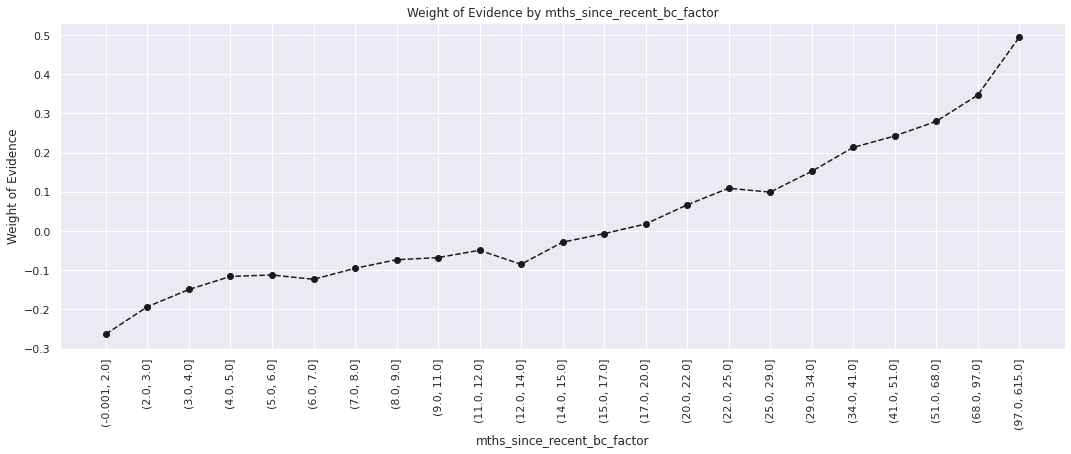

In [52]:
plot_by_woe(df_temp, 90)

In [53]:
X_train['mths_since_recent_bc:<=4'] = np.where((X_train['mths_since_recent_bc']<=4) | (X_train['mths_since_recent_bc'].isnull()), 1, 0)
X_train['mths_since_recent_bc:4-8'] = np.where((X_train['mths_since_recent_bc']>4) & (X_train['mths_since_recent_bc']<=8), 1, 0)
X_train['mths_since_recent_bc:8-14'] = np.where((X_train['mths_since_recent_bc']>8) & (X_train['mths_since_recent_bc']<=14), 1, 0)
X_train['mths_since_recent_bc:14-21'] = np.where((X_train['mths_since_recent_bc']>14) & (X_train['mths_since_recent_bc']<=21), 1, 0)
X_train['mths_since_recent_bc:21-29'] = np.where((X_train['mths_since_recent_bc']>21) & (X_train['mths_since_recent_bc']<=29), 1, 0)
X_train['mths_since_recent_bc:29-41'] = np.where((X_train['mths_since_recent_bc']>29) & (X_train['mths_since_recent_bc']<=41), 1, 0)
X_train['mths_since_recent_bc:41-68'] = np.where((X_train['mths_since_recent_bc']>41) & (X_train['mths_since_recent_bc']<=68), 1, 0)
X_train['mths_since_recent_bc:>68'] = np.where((X_train['mths_since_recent_bc']>68), 1, 0)
ref_cat.append('mths_since_recent_bc:<=4')

In [54]:
#mths_since_last_credit_pull_d
loan_data_inputs_train['mths_since_last_credit_pull_d_factor'] = pd.qcut(loan_data_inputs_train['mths_since_last_credit_pull_d'], 20,  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'mths_since_last_credit_pull_d_factor', loan_data_targets_train)
df_temp

,mths_since_last_credit_pull_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.001, 1.0]",713162,0.920257,0.533978,656292.0,56870.0,0.581966,0.273612,0.754700,NaN,NaN,0.786177
1,"(1.0, 2.0]",52943,0.854806,0.039641,45256.0,7687.0,0.040131,0.036984,0.081667,0.065450,0.673033,0.786177
2,"(2.0, 3.0]",43235,0.907621,0.032372,39241.0,3994.0,0.034797,0.019216,0.593791,0.052815,0.512124,0.786177
3,"(3.0, 5.0]",61812,0.877047,0.046282,54212.0,7600.0,0.048072,0.036565,0.273616,0.030575,0.320175,0.786177
4,"(5.0, 8.0]",89492,0.777745,0.067007,69602.0,19890.0,0.061719,0.095694,-0.438562,0.099301,0.712178,0.786177
5,"(8.0, 10.0]",46741,0.727049,0.034997,33983.0,12758.0,0.030134,0.061381,-0.711436,0.050696,0.272874,0.786177
6,"(10.0, 14.0]",70615,0.802167,0.052873,56645.0,13970.0,0.050230,0.067212,-0.291246,0.075118,0.420190,0.786177
7,"(14.0, 18.0]",59791,0.714355,0.044768,42712.0,17079.0,0.037875,0.082170,-0.774508,0.087812,0.483261,0.786177
8,"(18.0, 24.0]",66100,0.712905,0.049492,47123.0,18977.0,0.041786,0.091302,-0.781604,0.001450,0.007097,0.786177
9,"(24.0, 30.0]",82971,0.433670,0.062124,35982.0,46989.0,0.031907,0.226073,-1.958032,0.279235,1.176428,0.786177


drop this variable because the information value is suspiciously high (too good to be true)

In [55]:
#mths_credit_history
loan_data_inputs_train['mths_credit_history_factor'] = pd.cut(loan_data_inputs_train['mths_credit_history'], [0, 60, 120, 180, 240, 999],  duplicates='drop')
df_temp = woe_ordered_continuous(loan_data_inputs_train, 'mths_credit_history_factor', loan_data_targets_train)
df_temp

,mths_credit_history_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0, 60]",36456,0.812514,0.027295,29621.0,6835.0,0.026265,0.032883,-0.224719,NaN,NaN,0.014018
1,"(60, 120]",182071,0.822926,0.136320,149831.0,32240.0,0.132857,0.155107,-0.154846,0.010413,0.069873,0.014018
2,"(120, 180]",449209,0.834738,0.336330,374972.0,74237.0,0.332492,0.357156,-0.071557,0.011812,0.083289,0.014018
3,"(180, 240]",312929,0.851548,0.234295,266474.0,46455.0,0.236285,0.223496,0.055647,0.016809,0.127204,0.014018
4,"(240, 999]",354954,0.864520,0.265760,306865.0,48089.0,0.272101,0.231357,0.162209,0.012973,0.106562,0.014018


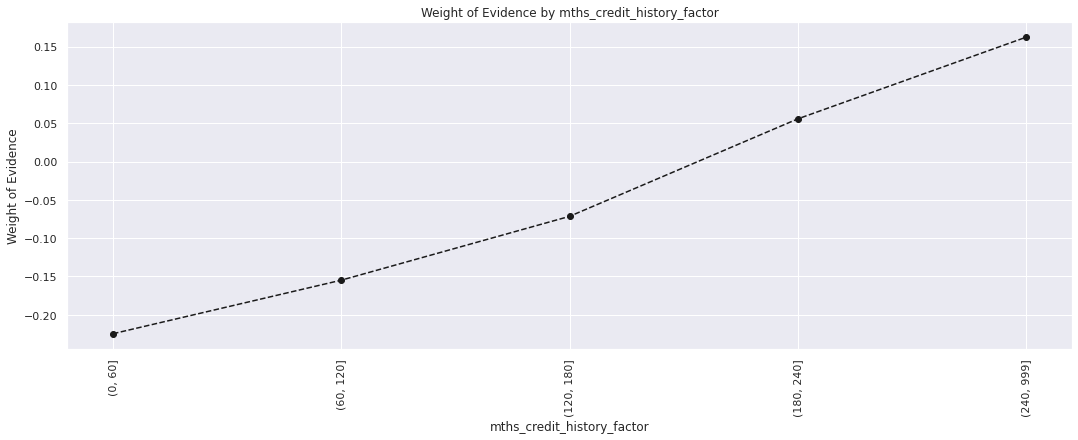

In [56]:
plot_by_woe(df_temp, 90)

In [57]:
#X_train['mths_credit_history:<=60'] = np.where((X_train['mths_credit_history']<=60) | (X_train['mths_credit_history'].isnull()), 1, 0)
#X_train['mths_credit_history:60-120'] = np.where((X_train['mths_credit_history']>60) & (X_train['mths_credit_history']<=120), 1, 0)
#X_train['mths_credit_history:120-180'] = np.where((X_train['mths_credit_history']>120) & (X_train['mths_credit_history']<=180), 1, 0)
#X_train['mths_credit_history:180-240'] = np.where((X_train['mths_credit_history']>180) & (X_train['mths_credit_history']<=240), 1, 0)
#X_train['mths_credit_history:>240'] = np.where((X_train['mths_credit_history']>240), 1, 0)
#ref_cat.append('mths_credit_history:<=60')
#low information value

In [58]:
list(X_train.columns)

['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'revol_bal',
 'all_util',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'mths_since_last_credit_pull_d',
 'mths_credit_history',
 'grade:A',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'grade:G',
 'home_ownership:ANY',
 'home_ownership:MORTGAGE',
 'home_ownership:NONE',
 'home_ownership:OWN',
 'home_ownership:RENT',
 'verification_status:Not Verified',
 'verification_status:Source Verified',
 'verification_status:Verified',
 'purpose:car',
 'purpose:credit_card',
 'purpose:debt_consolidation',
 'purpose:educational',
 'purpose:home_improvement',
 'purpose:house',
 'purpose:major_purchase',
 'purpose:medical',
 'purpose:moving',
 'purpose:other',
 'purpose:renewable_energy',
 'purpose:small_business',
 'purpose:vacation',
 'purpose:wedding',
 'addr_state:AK',
 'addr_state:AL',
 'addr_state:AR',
 'ad

In [61]:
feature_selected = ['grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','grade:G',
                    'home_ownership:RENT_NONE_ANY','home_ownership:MORTGAGE','home_ownership:OWN',
                    'verification_status:Not Verified','verification_status:Source Verified',
                    'verification_status:Verified','purpose:RE_MV_HS','purpose:med_other_wed', 
                    'purpose:debt_consolidation', 'purpose:vac_majp','purpose:home_cred','purpose:car_edu',
                    'purpose:small_business','addr_state:CA','addr_state:MA','addr_state:NY','addr_state:TX',
                    'addr_state:IA_AR_MS_AL_OK_LA','addr_state:NV_NM_SD','addr_state:FL_NE_TN_HI_MO_MD',
                    'addr_state:NJ_NC_IN_KY','addr_state:PA_VA_AK','addr_state:AZ_MI','addr_state:OH_MN_DE',
                    'addr_state:WI_UT_GA_WV_RI','addr_state:ND_WY_IL','addr_state:MT_KS_ID',
                    'addr_state:WA_CT_CO_SC','addr_state:NH_OR_DC_VT_ME','loan_amnt:<=1600',
                    'loan_amnt:1600-3500','loan_amnt:3500-5000','loan_amnt:5000-6000','loan_amnt:6000-7000',
                    'loan_amnt:7000-8000','loan_amnt:8000-9000','loan_amnt:9000-10000',
                    'loan_amnt:10000-35000','loan_amnt:>35000','term:36','term:60',
                    'int_rate:<=8.529','int_rate:8.529-11.738','int_rate:11.738-14.946','int_rate:14.946-18.155',
                    'int_rate:18.155-21.364','int_rate:>21.364',
                    'annual_inc:<35K','annual_inc:35K-43K','annual_inc:43K-50K','annual_inc:50K-58K',
                    'annual_inc:58K-65K','annual_inc:65K-75K','annual_inc:75K-85K','annual_inc:85K-100K',
                    'annual_inc:100K-130K','annual_inc:>130K','dti:<10','dti:10-15','dti:15-20','dti:20-25',
                    'dti:25-30','dti:>30','all_util:missing','all_util:<=30','all_util:30-40','all_util:40-50',
                    'all_util:50-60','all_util:60-70','all_util:>70','mort_acc:0','mort_acc:none-zero',
                    'mths_since_recent_bc:<=4','mths_since_recent_bc:4-8','mths_since_recent_bc:8-14',
                    'mths_since_recent_bc:14-21','mths_since_recent_bc:21-29',
                    'mths_since_recent_bc:29-41','mths_since_recent_bc:41-68','mths_since_recent_bc:>68']


In [62]:
X_train[feature_selected].to_csv('x_train.csv')

In [63]:
ref_cat

['grade:G',
 'verification_status:Verified',
 'home_ownership:RENT_NONE_ANY',
 'purpose:small_business',
 'addr_state:IA_AR_MS_AL_OK_LA',
 'loan_amnt:10000-35000',
 'term:60',
 'int_rate:>21.364',
 'annual_inc:<35K',
 'dti:>30',
 'all_util:>70',
 'mort_acc:0',
 'mths_since_recent_bc:<=4']